# NASA 데이터 기반 ‘최적’ 예지보전 정책 한계 및 확장 방향

## 단순 임계값 기반 경고 수준을 넘어, 실제 보전 시점, 방식, 비용 최적화를 수리적으로 도출하는 것
✅ 2. 요구 입력 데이터  
센서 시계열 (e.g., s9, s4, s12, s7 등)  
각 엔진 단위별 운용 이력 (unit, cycle)  
RUL 레이블 or 추정값  
보전 유형별 비용 구조 (optional)  
- 예방 정비 비용 (C_pm)  
- 고장 정비 비용 (C_fail)  
- 예지 정비 비용 (C_cbm)  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyALE import ale
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# 1. 데이터 불러오기
df = pd.read_csv("../data/processed_train.csv")  # 파일 경로 수정 필요
df = df.drop(columns=["s11"])  # 과도 의존성 제거

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def train_RUL_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

In [5]:
# 중요 센서 기반 RUL 예측 모델
X = df[["s9", "s4", "s12", "s7"]]  # 주요 센서
y = df["RUL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = train_RUL_model(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

In [6]:
# RUL 예측 
model = train_RUL_model(X_train, y_train)
predicted_RUL = model.predict(X_test)

In [7]:
from sklearn.linear_model import LinearRegression

def predict_threshold_crossing(feature_series, threshold):
    X = np.arange(len(feature_series)).reshape(-1, 1)
    y = feature_series.values
    model = LinearRegression().fit(X, y)
    slope, intercept = model.coef_[0], model.intercept_
    
    if slope >= 0:
        return None  # 감소 경향이 없으면 도달 불가

    crossing_time = (threshold - intercept) / slope
    return crossing_time if crossing_time >= 0 else None

In [8]:
# CBM 의사결정 로직 기초
def cbm_decision(pred_rul, cbm_threshold=30, cost_cbm=100, cost_fail=500):
    """
    RUL 예측값 기반으로 CBM 수행 여부 판단
    - 예지보전 임계값 이하이면 보전 수행
    """
    if pred_rul <= cbm_threshold:
        return 'CBM', cost_cbm
    else:
        return 'No action', 0

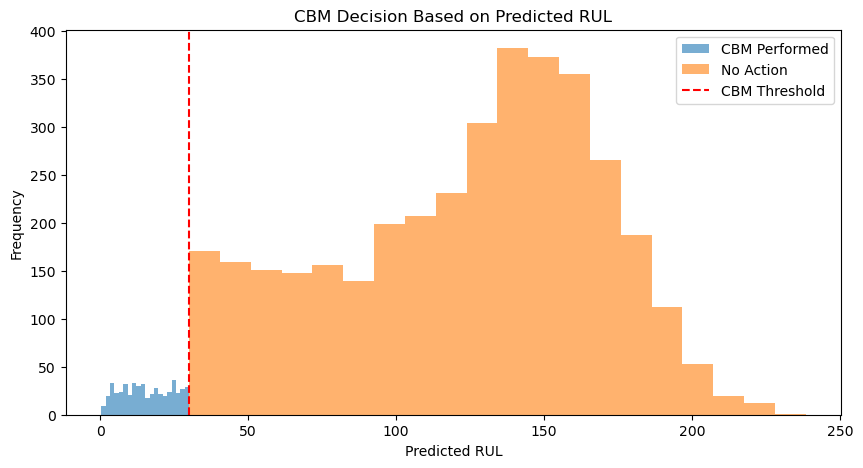

In [9]:
# 1. CBM 판단 로직 적용
cbm_threshold = 30  # 예: 30 사이클 이하부터 예지보전 수행
cost_cbm = 100
cost_fail = 500

decisions = []
costs = []

for rul in predicted_RUL:
    decision, cost = cbm_decision(rul, cbm_threshold, cost_cbm, cost_fail)
    decisions.append(decision)
    costs.append(cost)

# 2. 결과 저장
result_df = pd.DataFrame({
    "Predicted_RUL": predicted_RUL,
    "Decision": decisions,
    "Maintenance_Cost": costs
})

# 3. 시각화 (보전 수행 여부 및 비용 분포)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(result_df[result_df["Decision"] == "CBM"]["Predicted_RUL"], bins=20, alpha=0.6, label="CBM Performed")
plt.hist(result_df[result_df["Decision"] == "No action"]["Predicted_RUL"], bins=20, alpha=0.6, label="No Action")
plt.axvline(cbm_threshold, color='red', linestyle='--', label='CBM Threshold')
plt.xlabel("Predicted RUL")
plt.ylabel("Frequency")
plt.legend()
plt.title("CBM Decision Based on Predicted RUL")
plt.show()

🔎 주요 해석  
1. 보전 수행 대상의 분포  
- CBM 수행 필요 장비 수는 예측 RUL이 낮은 구간(0~30)에 집중 분포되어 있음.  
- 해당 장비는 곧 고장 가능성이 높으므로, 예지보전 수행이 바람직함. 

2. 대다수 장비는 아직 보전 불필요  
- 예측 RUL이 100 이상인 장비가 가장 많으며, 이는 상태가 양호한 장비가 많음을 시사함.  
- 따라서 전체 정비 자원을 효율적으로 활용하려면, 이 구간 장비는 보전 제외 또는 유예가 가능함.  

3. CBM 임계값 기준의 직관적 구분  
- 시각화를 통해 **임계값(RUL=30)**을 기준으로 보전 수행 여부를 자동 분류할 수 있음.  
- 이는 단순 경고 기반 유지보수보다 더 체계적이고 수리적인 의사결정 지원이 가능함을 의미.  

# NASA 데이터 기반 ‘최적’ 예지보전 정책 한계 및 확장 방향

## 단순 임계값 기반 경고 수준을 넘어, 실제 보전 시점, 방식, 비용 최적화를 수리적으로 도출하는 것
✅ 요구 입력 데이터  
센서 시계열 (e.g., s9, s4, s12, s7 등)  
각 엔진 단위별 운용 이력 (unit, cycle)  
RUL 레이블 or 추정값  
보전 유형별 비용 구조 (optional)  
- 예방 정비 비용 (C_pm)  
- 고장 정비 비용 (C_fail)  
- 예지 정비 비용 (C_cbm)  

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyALE import ale
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [11]:
# 1. 데이터 불러오기
df = pd.read_csv("../data/processed_train.csv")  # 파일 경로 수정 필요
df = df.drop(columns=["s11"])  # 과도 의존성 제거

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def train_RUL_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

In [13]:
# 중요 센서 기반 RUL 예측 모델
X = df[["s9", "s4", "s12", "s7"]]  # 주요 센서
y = df["RUL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = train_RUL_model(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

In [14]:
# RUL 예측 
model = train_RUL_model(X_train, y_train)
predicted_RUL = model.predict(X_test)

In [15]:
from sklearn.linear_model import LinearRegression

def predict_threshold_crossing(feature_series, threshold):
    X = np.arange(len(feature_series)).reshape(-1, 1)
    y = feature_series.values
    model = LinearRegression().fit(X, y)
    slope, intercept = model.coef_[0], model.intercept_
    
    if slope >= 0:
        return None  # 감소 경향이 없으면 도달 불가

    crossing_time = (threshold - intercept) / slope
    return crossing_time if crossing_time >= 0 else None

In [16]:
# CBM 의사결정 로직 기초
def cbm_decision(pred_rul, cbm_threshold=30, cost_cbm=100, cost_fail=500):
    """
    RUL 예측값 기반으로 CBM 수행 여부 판단
    - 예지보전 임계값 이하이면 보전 수행
    """
    if pred_rul <= cbm_threshold:
        return 'CBM', cost_cbm
    else:
        return 'No action', 0

 확률 기반 예지보전 정책 최적화

In [17]:

threshold = 30      # RUL 임계값
cost_cbm = 100      # 예지보전 비용
cost_fail = 500     # 고장 정비 비용

# (1) 모델 예측 분포 계산
all_preds = np.stack([tree.predict(X_test) for tree in model.estimators_], axis=1)
mean_pred = all_preds.mean(axis=1)
std_pred = all_preds.std(axis=1)

# (2) RUL이 threshold 이하일 확률 (고장 확률)
from scipy.stats import norm
prob_failure = norm.cdf(threshold, loc=mean_pred, scale=std_pred)

# (3) 기대 비용 계산
expected_cost = prob_failure * cost_fail + (1 - prob_failure) * cost_cbm
print(expected_cost)

[103.24863043 484.53563453 100.76934738 ... 118.78050593 101.07070458
 114.02553373]


/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jimin/miniforge3/envs/zero/l

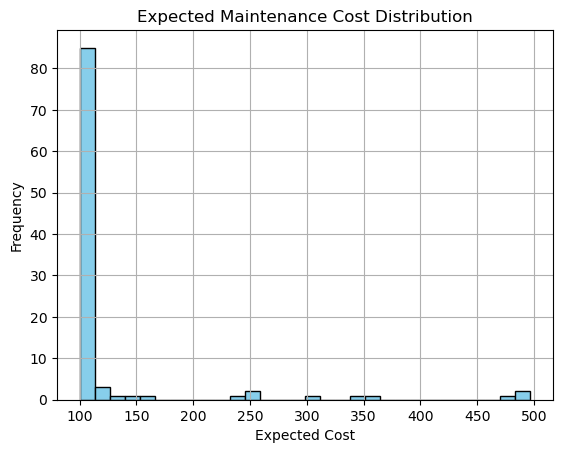

In [18]:


# 임의의 예시값 (실제 예측 결과에 맞게 수정 필요)
mean_pred = np.random.normal(loc=50, scale=10, size=100)
std_pred = np.random.normal(loc=5, scale=1, size=100)

# 고장 확률 계산
prob_failure = norm.cdf(threshold, loc=mean_pred, scale=std_pred)

# 기대 비용 계산
expected_cost = prob_failure * cost_fail + (1 - prob_failure) * cost_cbm

# 시각화
import matplotlib.pyplot as plt
plt.hist(expected_cost, bins=30, color='skyblue', edgecolor='black')
plt.title('Expected Maintenance Cost Distribution')
plt.xlabel('Expected Cost')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

1. 대다수 유닛의 기대 비용이 매우 낮다  
- 100 근처에 몰림: 대부분의 예측에서 RUL > threshold라는 뜻 → 예지보전 성공 가능성 높음  
- 예측 불확실성(표준편차)이 낮아, 대부분 예지보전 시기 이전에 정비 가능  

2. 일부 유닛은 높은 비용 발생 가능성 존재  
- 일부는 250~500 구간에 분포 → 고장확률이 높거나 예측 불확실성 큼  
- 이런 유닛은 정밀 모니터링 또는 조기 정비 필요  

3. 정책 기준으로 효율적임을 시사  
- 평균 기대 비용이 100~150 사이: 고장 확률이 낮아 예지보전 위주의 정책이 경제적임  

### 일부 예외 유닛에서 불확실성이 크므로, 예측 모델의 신뢰도 기반 정책 보완이 필요

In [26]:
# CBM 정책 vs 예방정비 정책 비용 시뮬레이션

# # 보수적 시나리오 (낮은 비용 차이)
# C_fail_low = 300
# C_pm_low = 150
# C_cbm_low = 80

# 기본 시나리오 (중간값)
C_fail = 500
C_pm = 200
C_cbm = 100

# # 공격적 가정
# C_fail_high = 800
# C_pm_high = 300
# C_cbm_high = 120

threshold = 30


# CBM 정책 비용
cbm_policy_cost = np.sum([
    prob_failure[i] * C_fail + (1 - prob_failure[i]) * C_cbm 
    for i in range(len(prob_failure))
]) / len(prob_failure)

# 예방정비 정책 비용 (정기적으로 C_pm)
pm_policy_cost = C_pm  # 모든 엔진에 동일하게 적용

# 절감 비용 계산
savings = (pm_policy_cost - cbm_policy_cost) / pm_policy_cost * 100

print(f"CBM 정책 평균 비용: ${cbm_policy_cost:.2f}")
print(f"예방정비 정책 비용: ${pm_policy_cost:.2f}")
print(f"절감율: {savings:.1f}%")


CBM 정책 평균 비용: $126.22
예방정비 정책 비용: $200.00
절감율: 36.9%
